# Introduction

The European Transaction Log (EUTL) is the backbone of the European Union Emissions Trading System (EUETS). It implements the transfer of emission allowances between parties active in the EUETS. The EUTL provides data on regulated installations, their emissions as well as transfers of allowances.  

Assuming that the database has been successfully populated with the EUTL data (see 1_create_database.ipynb), this notebook illustrates how to analyze compliance and transactions on the registry level.

Specifically, we consider the German registry with the identifier DE.

In [1]:
id_reg = "DE"

# Packages and options

In [3]:
from pyeutl.orm import DataAccessLayer       # data access layer to access the database
from pyeutl.orm import Country, Installation  # use country class to access registries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Database connection settings

In [4]:
connectionSettings = dict(
    user="eutlAdmin", 
    host="localhost", 
    db="eutl_orm", 
    passw="1234",
    port=5432
)

# Connect to database

Connect to database and get a session:

In [5]:
dal = DataAccessLayer(**connectionSettings)
session = dal.session

# Get registry

Given the registry id, use the session to get the registry:

In [6]:
registry = session.query(Country).get(id_reg)
print(registry.id + ": " + registry.name)

DE: Germany


# Installations

## Low-level access: Get installation objects

The country object has a property "installations_in_registry" which returns the query to get all installations registered in the country. The property "installations_in_country" returns all installations located in the country. 

In [7]:
inst = registry.installations_in_registry
inst

Given the query we can either fetch the results:

In [8]:
inst.first()          # get only first results
inst.all()            # get all results
inst.limit(5).all()   # get first 5 results 

[<Installation('DE_202868', None, <Country('DE', 'Germany')>)>,
 <Installation('DE_612', 'Papierfabrik MPF', <Country('DE', 'Germany')>)>,
 <Installation('DE_371', 'Ziegelwerk Schönlind', <Country('DE', 'Germany')>)>,
 <Installation('DE_90', 'Zementwerk Paderborn', <Country('DE', 'Germany')>)>,
 <Installation('DE_2796', 'Speicherverdichterstation Krummhörn', <Country('DE', 'Germany')>)>]

We could also further filter the results, e.g., getting all installations under activity 1 or 20 (combustion of fuels):

In [9]:
t_ = inst.filter(Installation.activity_id.in_([1, 20])).all()
print("Number of combustion installations: ", len(t_))

Number of combustion installations:  1486


## More easy: get_installations()

The low-level access is useful to directly get the installation objects which allows constructing different filters. For convenience, get_installations() implements a method that returns all installations in the registry as a Pandas dataframe.

In [10]:
inst = registry.get_installations()
inst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2794 entries, 0 to 2793
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   isAircraftOperator   2794 non-null   bool          
 1   subsidiaryCompany    1953 non-null   object        
 2   longitudeEutl        11 non-null     float64       
 3   ec748_2009Code       181 non-null    object        
 4   permitID             2613 non-null   object        
 5   latitudeGoogle       2611 non-null   float64       
 6   permitDateEntry      2612 non-null   datetime64[ns]
 7   designatorICAO       84 non-null     object        
 8   longitudeGoogle      2611 non-null   float64       
 9   id                   2794 non-null   object        
 10  addressMain          2794 non-null   object        
 11  monitoringID         181 non-null    object        
 12  nace15_id            2288 non-null   object        
 13  name                 2613 non-nul

To get an overview about the number of activities we can use a simple groupby operation but need to to be aware that some installations do not have a Nace code assigned:

In [11]:
inst.groupby("nace", dropna=False)[["id"]].count().sort_values("id", ascending=False).head(5)

,id
nace,
Steam and air conditioning supply,598
NaN,310
Production of electricity,257
Manufacture of paper and paperboard,159
"Manufacture of bricks, tiles and construction products, in baked clay",152


Most installations provide either heat or electricity (or both). The large number of NaN results from aircraft operators that do not have a nace code assigned: 

In [12]:
inst[pd.isnull(inst.nace)].groupby(["activity", "activity_id"])[["id"]].count()\
        .sort_values("id", ascending=False).head(4)

,,id
activity,activity_id,
Aircraft operator activities,10,181
Production of bulk chemicals,42,54
Combustion of fuels,20,45
Combustion installations with a rated thermal input exceeding 20 MW,1,9


The get_installation() method implements allows filtering installations based on installation attributes. For this, provide a dictionary with the installation attribute as key and a *list* as values. The dataframe returned only includes installations with attribute values as given in the respective list.

As an example, filter again for installations related to combustion activities:

In [13]:
filt = {"activity_id": [1, 20]}
t_ = registry.get_installations(filter=filt)
print("Number of combustion installations: ", len(t_))

Number of combustion installations:  1486


In [14]:
registry.get_installations(filter=filt).activity_id.unique()

array([ 1, 20], dtype=int64)

# Compliance

## Low-level: Using installation objects

Given a list of installation objects, we can analyze each installation in same manner as outline in the previous notebook. 

As an example, consider getting all compliance data for combustion activities in the selected registry:

In [15]:
comb = registry.installations_in_registry.filter(Installation.activity_id.in_([1, 20])).all()
print("Number of combustion installations: ", len(comb))

Number of combustion installations:  1486


Now follow the previous notebook and get the compliance data:

In [16]:
df_comb = pd.concat([c.get_compliance() for c in comb])
df_comb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38636 entries, 0 to 25
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   allocatedNewEntrance    17167 non-null  object
 1   installation_id         38636 non-null  object
 2   compliance_id           17936 non-null  object
 3   year                    38636 non-null  int64 
 4   surrenderedCummulative  17920 non-null  object
 5   verifiedUpdated         38636 non-null  bool  
 6   verified                17234 non-null  object
 7   allocatedTotal          17167 non-null  object
 8   allocatedFree           17167 non-null  object
 9   euetsPhase              38636 non-null  object
 10  surrendered             16794 non-null  object
 11  verifiedCummulative     17537 non-null  object
 12  allocated10c            17167 non-null  object
 13  compliance              17936 non-null  object
dtypes: bool(1), int64(1), object(12)
memory usage: 4.2+ MB


Accessing data in this way, has the advantage to be rather flexible in allowing to access that data for each installation. However, that comes at performance cost. Moreover, you either need to join installation information like names and activities or to further aggregate the data. 

Therefore, the country object provides further methods that already include these information and aggregations.

## High level: get_compliance()

get_compliance() returns a dataframe of compliance data related to the registry including limited installation details:

In [17]:
df_comp = registry.get_compliance()
df_comp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72463 entries, 0 to 72462
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   installation_id       72463 non-null  object 
 1   installation_name     67938 non-null  object 
 2   activity_id           72463 non-null  int64  
 3   activity              72463 non-null  object 
 4   nace_id               64584 non-null  object 
 5   nace                  64584 non-null  object 
 6   year                  72463 non-null  int64  
 7   surrendered           28230 non-null  float64
 8   verified              29419 non-null  float64
 9   allocatedTotal        30027 non-null  float64
 10  allocatedFree         30027 non-null  float64
 11  allocated10c          30027 non-null  float64
 12  allocatedNewEntrance  30027 non-null  float64
 13  nace_category         72463 non-null  object 
 14  activity_category     72463 non-null  object 
dtypes: float64(6), int6

The frame allows to easily aggregate compliance data by the respective dimension. As an example, plot verified emissions by NACE category over time:

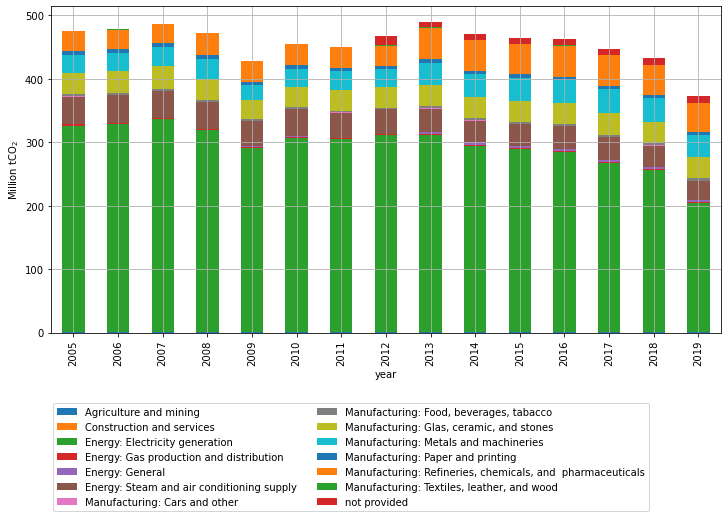

In [18]:
ax = df_comp[df_comp.year < 2020].groupby(["year", "nace_category"], as_index=False)\
        .verified.sum()\
        .pivot_table("verified", "year", "nace_category", dropna=False).div(1000000)\
        .plot(kind="bar", stacked=True,  figsize=(12,6), ylabel=r"Million tCO$_2$", grid=True)
ax.legend(bbox_to_anchor=(0.9, -0.2), loc=0, ncol=2)

Likewise, by activity category:

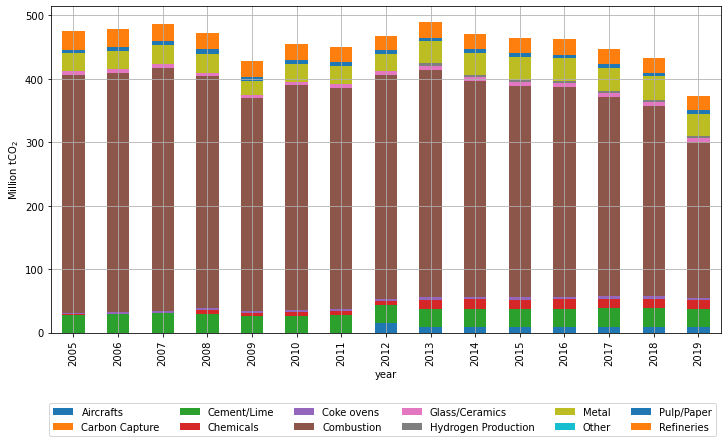

In [19]:
ax = df_comp[df_comp.year < 2020].groupby(["year", "activity_category"], as_index=False)\
        .verified.sum()\
        .pivot_table("verified", "year", "activity_category", dropna=False).div(1000000)\
        .plot(kind="bar", stacked=True,  figsize=(12,6), ylabel=r"Million tCO$_2$", grid=True)
ax.legend(bbox_to_anchor=(1, -0.2), loc=0, ncol=6)